# Suicide detection ML module
created by: Chunlin An


This module is an extension of existing suicidal detection ML module created by
Godhuli-De on [GitHub](https://github.com/Godhuli-De/SuicidePrediction-TextProcessing/blob/main/suicide-detection-eda-98.ipynb), utilizing an existing labeled dataset on [Kaggle](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch) containing 232074 suicidal social media entries.
We expanded the model to 1) incorporating another dataset on [Kaggle](https://www.kaggle.com/datasets/neelakshigupta/suicide-detection) containing 10000 entries, as well as conducting cross-validation hoping to strenghten the model's performance and generalizability.

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn wordcloud pickle warnings tqdm


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd "D:\CU\Practicum FALL\data"

D:\CU\Practicum FALL\data


# Load datasets

In [ ]:
# import data 

df1 = pd.read_csv("Suicide_Detection.csv")
df2 = pd.read_csv("file1.csv")


In [5]:
df1.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
df2.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,suicide
1,149516,start becom rich start compani becom 16 afford...,non-suicide
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [6]:
# Convert target labels into numeric format
label_encoder = LabelEncoder()
df1['class'] = label_encoder.fit_transform(df1['class'])  # Encode "suicide" (1) and "non-suicide" (0)

In [8]:
df1.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,0
2,4,Finally 2020 is almost over... So I can never ...,0
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [7]:
df2['class'] = label_encoder.fit_transform(df2['class'])
df2.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,1
1,149516,start becom rich start compani becom 16 afford...,0
2,12484,poem haiku umegamedev hi hello hello stop fuck...,0
3,14043,ive honestli got idea anymoreit feel everyon f...,1
4,30673,ever cri like think unfair life cri cant cri e...,0


#  Merge datasets

In [8]:
data = pd.concat([df1, df2], axis = 0)
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 242074 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  242074 non-null  int64 
 1   text        242073 non-null  object
 2   class       242074 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.4+ MB
None
   Unnamed: 0                                               text  class
0           2  Ex Wife Threatening SuicideRecently I left my ...      1
1           3  Am I weird I don't get affected by compliments...      0
2           4  Finally 2020 is almost over... So I can never ...      0
3           8          i need helpjust help me im crying so hard      1
4           9  I’m so lostHello, my name is Adam (16) and I’v...      1


# Data preprocessing

In [9]:
%pip install nltk 
import nltk
# Ensure necessary NLTK data is downloaded


Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_data(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Tokenize
    words = nltk.word_tokenize(text)

    # 3. Remove punctuation
    words = [word for word in words if word.isalnum()]

    # 4. Remove stop words
    filtered_words = [word for word in words if word not in stop_words]

    # 5. Apply Porter Stemmer
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    return " ".join(stemmed_words)

# Test it
sample_text = "The quick brown foxes are running in the fields!"
cleaned_data = clean_text_data(sample_text)
print(cleaned_data)


quick brown fox run field


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acl13\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acl13\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Clean and save preprocessed data 

In [12]:
data = data.dropna()
data["text"] = data["text"].apply(clean_text_data)
data.head()

,Unnamed: 0,text,class
0,2,ex wife threaten suiciderec left wife good che...,1
1,3,weird get affect compliment come someon know i...,0
2,4,final 2020 almost never hear 2020 bad year eve...,0
3,8,need helpjust help im cri hard,1
4,9,losthello name adam 16 struggl year afraid pas...,1


In [13]:
with open ('data', 'wb') as file:
    pickle.dump(data, file)

In [14]:
data = joblib.load("data")

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.2, random_state=42)


# Text Processing using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

In [17]:
# save train and test datasets
with open ('X_train_tfidf', 'wb') as file:
    pickle.dump(X_train_tfidf, file)

with open ('X_test_tfidf', 'wb') as file:
    pickle.dump(X_test_tfidf, file)

with open ('y_train', 'wb') as file:
    pickle.dump(y_train, file)

with open ('y_test', 'wb') as file:
    pickle.dump(y_test, file)

# Logistic Regression Model

In [18]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)
print("\nLogistic Regression Model Performance:")
print(classification_report(y_test, lr_preds))


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     24124
           1       0.94      0.92      0.93     24291

    accuracy                           0.93     48415
   macro avg       0.93      0.93      0.93     48415
weighted avg       0.93      0.93      0.93     48415



In [20]:
# improving model with gridsearch cv

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_
best_lr_preds = best_lr_model.predict(X_test_tfidf)

print("\nBest Logistic Regression Model Parameters:")
print(best_params)
print("\nBest Logistic Regression Model Performance:")
print(classification_report(y_test, best_lr_preds))


Best Logistic Regression Model Parameters:
{'C': 10}

Best Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     24124
           1       0.94      0.93      0.93     24291

    accuracy                           0.93     48415
   macro avg       0.93      0.93      0.93     48415
weighted avg       0.93      0.93      0.93     48415



In [21]:
# export model

with open('lr_best', 'wb') as file:
        pickle.dump(best_lr_model, file)

In [22]:
# export vectorizer

with open('myvec', 'wb') as file:
        pickle.dump(vectorizer, file)

In [37]:
best_lr = joblib.load("lr_best")


In [19]:
    
with open("lr_best", "rb") as f:
    lr_best = pickle.load(f)
lr_best.fit(X_train, y_train)
best_lr_preds = lr_best.predict(X_test)

# Random Forest Model

In [7]:
rf_model = RandomForestClassifier(n_estimators=60, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))


Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     24198
           1       0.89      0.92      0.90     24217

    accuracy                           0.90     48415
   macro avg       0.90      0.90      0.90     48415
weighted avg       0.90      0.90      0.90     48415



In [8]:
# improve rf model with gridsearch cv
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=3,
                           scoring = 'accuracy',
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_rf = grid_search.best_params_
best_rf = grid_search.best_estimator_
best_rf_preds = best_rf.predict(X_test)

In [10]:
print("\nBest Random Forest Model Parameters:")
print(best_params_rf)
print("\nBest Random Forest Model Performance:")
print(classification_report(y_test, best_rf_preds))
    



Best Random Forest Model Parameters:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Best Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     24198
           1       0.90      0.92      0.91     24217

    accuracy                           0.91     48415
   macro avg       0.91      0.91      0.91     48415
weighted avg       0.91      0.91      0.91     48415



In [11]:
# export model

with open('rf_best', 'wb') as file:
        pickle.dump(best_rf, file)

# XGBoost Model

In [14]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     24198
           1       0.93      0.89      0.91     24217

    accuracy                           0.91     48415
   macro avg       0.91      0.91      0.91     48415
weighted avg       0.91      0.91      0.91     48415



In [15]:
# improve xgboost model with gridsearch cv

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_
best_xgb_preds = best_xgb_model.predict(X_test)

print("\nBest XGBoost Model Parameters:")
print(best_params)
print("\nBest XGBoost Model Performance:")
print(classification_report(y_test, best_xgb_preds))



Best XGBoost Model Parameters:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

Best XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     24198
           1       0.93      0.89      0.91     24217

    accuracy                           0.91     48415
   macro avg       0.91      0.91      0.91     48415
weighted avg       0.91      0.91      0.91     48415



In [16]:
with open('xgb_best', 'wb') as file:
        pickle.dump(best_xgb_model, file)


# Confusion Matrices

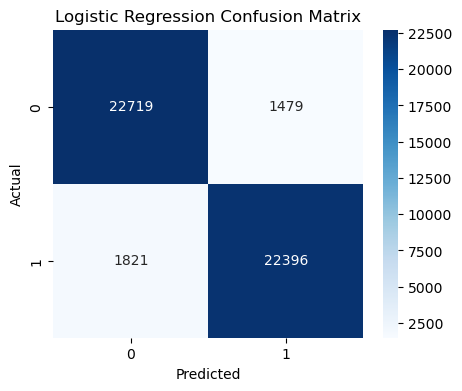

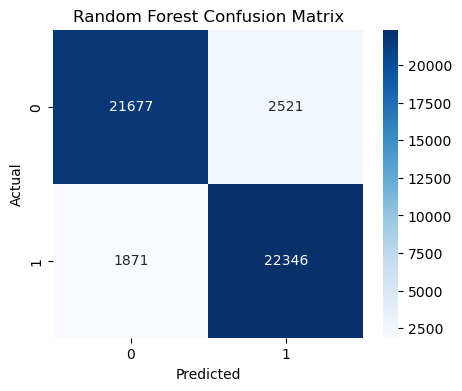

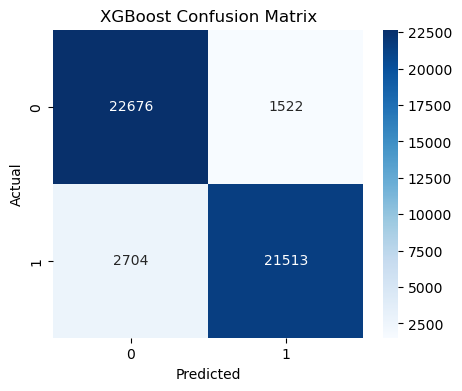

In [20]:
# Plot Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, best_lr_preds, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, best_rf_preds, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, best_xgb_preds, "XGBoost Confusion Matrix")